In [1]:
# import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random,datetime

# Data Manipulation
import numpy as np
import pandas as pd
import scipy as sp

#Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
import catboost
import lightgbm as lgb
 
from collections import Counter
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool, cv
from functools import partial
from math import sqrt


# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [97]:
#import train and test data
train = pd.read_csv('newTrain.csv')
cleanTrain = pd.read_csv('train_ims_merged_drop100.csv')
test = pd.read_csv('test_ims_merged_drop100.csv')
train2 = pd.read_csv('train2.csv')
breedlabel = pd.read_csv('breed_labels.csv')

## What missing values are there?
Where are the holes in our data?
These are the rows which are missing a value

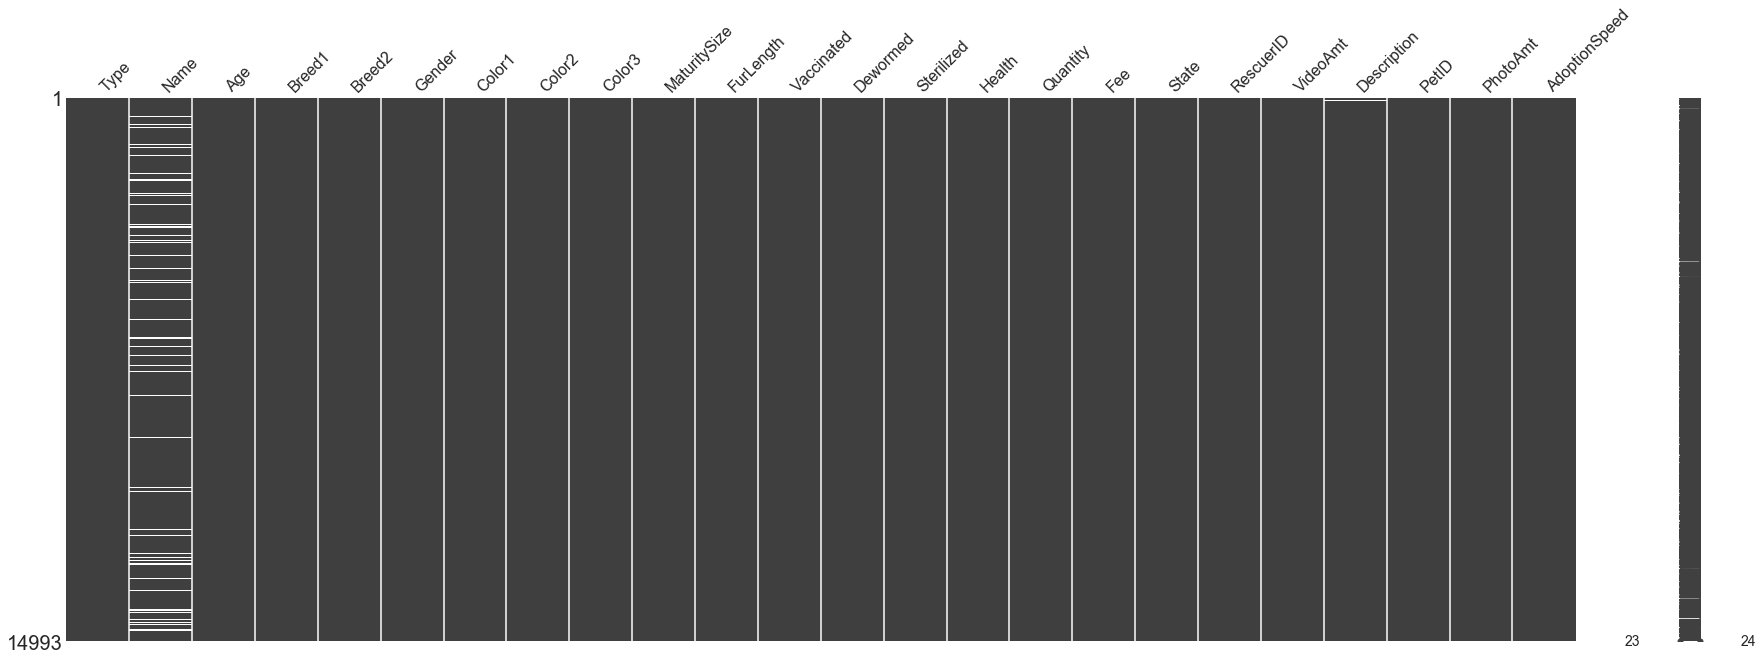

In [66]:
missingno.matrix(train, figsize=(30, 10))

__This is a function that finds the missing values in our dataset and gives the counted missing values for each column__

In [67]:
def find_missing_values(df, columns):
    missing_vals = {}
    print('Number of missing values for each column:')
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
    return missing_vals

missing_values = find_missing_values(train, columns=train.columns)
missing_values

Number of missing values for each column:


{'Type': 0,
 'Name': 1257,
 'Age': 0,
 'Breed1': 0,
 'Breed2': 0,
 'Gender': 0,
 'Color1': 0,
 'Color2': 0,
 'Color3': 0,
 'MaturitySize': 0,
 'FurLength': 0,
 'Vaccinated': 0,
 'Dewormed': 0,
 'Sterilized': 0,
 'Health': 0,
 'Quantity': 0,
 'Fee': 0,
 'State': 0,
 'RescuerID': 0,
 'VideoAmt': 0,
 'Description': 12,
 'PetID': 0,
 'PhotoAmt': 0,
 'AdoptionSpeed': 0}

## What datatypes are in the dataframe

Goal for next few steps is to figure out how best to process the data so our machine learning model can learn from it.
Ideally, all the features will be encoded into a numerical value of some kind.

In [68]:
train.dtypes

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

## Exploring each of the features individually
We'll go through each column iteratively and see which ones to use in our first models. Some may need more preprocessing than others to get ready.

In [69]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


### Target Feature: Adoption Speed
Description: 
Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:<br/>
0 - Pet was adopted on the same day as it was listed.<br/> 
1 - Pet was adopted between 1 and 7 days (1st week) after being listed.<br/> 
2 - Pet was adopted between 8 and 30 days (1st month) after being listed.<br/> 
3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.<br/> 
4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).<br/>

This is the variable we want our machine learning model to predict based off all the others.


4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64


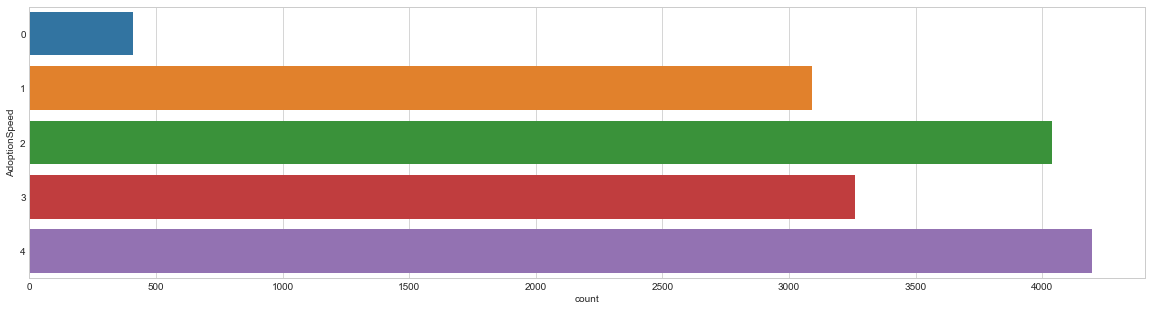

In [70]:
# Bar graph showing count of pets in categories ranging from 0 to 4
fig = plt.figure(figsize = (20,5))
sns.countplot(y='AdoptionSpeed', data=train)
print(train.AdoptionSpeed.value_counts())

In [71]:
#Create two new dataframes one for exploring continuous variables which
#have been sorted into categories and other that hasn't.

df_bin = pd.DataFrame()
df_con = pd.DataFrame()

In [72]:
#Let's add this to our subset dataframes
df_bin['AdoptionSpeed'] = train['AdoptionSpeed']
df_con['AdoptionSpeed'] = train['AdoptionSpeed']

### Feature Type
Description: Type of animal (1 = Dog, 2 = Cat)

#### Let's plot the distribution
We look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.
For Example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

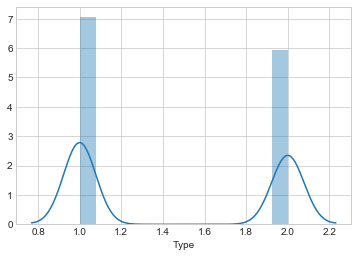

In [73]:
sns.distplot(train.Type)

We can see with this feature, the values are numerical(1 and 2) but they are categories<br/>
Since there are no missing values in the Type Column, let's add it to our sub dataframes

In [74]:
df_bin['Type'] = train['Type']
df_con['Type'] = train['Type']

### Feature Name 
Description: Name of pet (Empty if not named)

In [75]:
#How many missing values does name have?
missing_values['Name']

1257

In [59]:
cnt = Counter()
for word in train['Name'] :
    cnt[word] +=1
    
commonNames = cnt.most_common(115)



#uncommonNames = cnt.most_common()[:-n:-1]

#uncommonNames.sort(key = lambda x: x[1]) 


counter = 0
changed = False
for name in tqdm_notebook((train['Name']), desc ='replacing common and uncommon names'):
    for common in commonNames:
        if name == common[0] or type(name) == float:
            train.loc[counter,'Name'] = '1'
            changed = True;
            break;
    if(changed == False):
        train.loc[counter,'Name'] = '0'
    counter+=1
    changed = False





#for common in tqdm_notebook((commonNames), desc ='replacing common names'):
#      train = train.replace(common[0],'1')

        
#cnt = Counter()
#for word in train['Name'] :
#    cnt[word] +=1
    
#n = len(cnt)-1        
#uncommonNames = cnt.most_common()[-n:]       

#for common in tqdm_notebook((uncommonNames), desc ='replacing uncommon names'):
#      train = train.replace(common[0],'0')

#train.head()
#dictOfWords = {i : commonNames[i] for i in range(0, len(commonNames))}




In [60]:
#Converting column to numeric
train['Name']=pd.to_numeric(train['Name'])





In [61]:
train['Name'].value_counts()

0    11482
1     3511
Name: Name, dtype: int64

Roughly close to 12% of our dataset is missing a Name<br/>
Once we figure out what to do with this and make the fixes then we can add it to our sub dataframes.

### Feature Age
Description: Age of pet when listed, in months

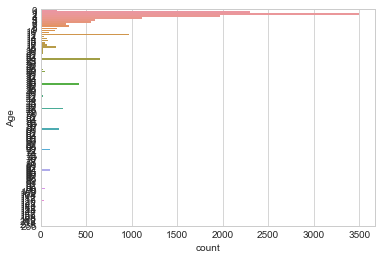

In [76]:
sns.countplot(y='Age', data=train )

In [77]:
#Check to see where most of our data lies in terms of age of pet when they were listed.
train.Age.value_counts()

2      3503
1      2304
3      1966
4      1109
12      967
24      651
5       595
6       558
36      417
8       309
7       281
48      241
60      199
9       184
0       179
18      165
10      162
72      104
84      102
11       94
15       79
14       76
17       67
30       52
16       50
96       46
13       40
120      33
20       32
21       28
       ... 
40        2
255       2
92        2
45        2
180       2
66        1
95        1
86        1
87        1
117       1
85        1
69        1
102       1
156       1
88        1
100       1
81        1
68        1
238       1
168       1
44        1
135       1
147       1
123       1
91        1
75        1
122       1
82        1
74        1
43        1
Name: Age, Length: 106, dtype: int64

In [78]:
df_bin['Age'] = train['Age']
df_con['Age'] = train['Age']

In [79]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20,5), use_bin_df=False):
    
    if use_bin_df:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df)
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1])

### Feature: Breed1
Description: Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)

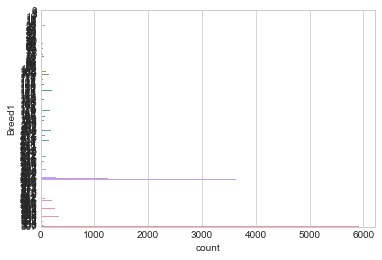

In [80]:
#How many different breeds do we have in our dataset and show counts for them.
sns.countplot(y='Breed1', data=train )

In [81]:
result = pd.merge(train, breedlabel[['Breed1', 'BreedName']], on='Breed1')
result.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,BreedName
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,Tabby
1,2,Mimi,12,299,0,2,3,6,7,2,...,2,0,41324,08e6e9a38d5c2275b28c2ae4432c9130,0,"Manja, comel ,dan memahami perasaan org.",1bf1f95ef,1.0,4,Tabby
2,2,Tabby Male,48,299,0,1,1,2,7,3,...,1,20,41326,c28d7a4697a2b731ec973c4c95ff8321,0,"This tabby was found by the clinic, has been s...",987baa1c7,4.0,2,Tabby
3,2,Manja,4,299,0,2,1,2,0,2,...,5,0,41336,655bd08f522480595e4c5d85dfb94be3,0,Found her when she's just about a weeks old at...,5c546c236,1.0,4,Tabby
4,2,Cham,8,299,0,1,3,0,0,2,...,1,0,41326,d8af7afece71334473575c9f70daf00d,0,My cat's offspring Cham is lively and loves pl...,c2346525a,2.0,2,Tabby


In [82]:
result.BreedName.value_counts()

Mixed Breed                     5927
Domestic Short Hair             3634
Domestic Medium Hair            1258
Tabby                            342
Domestic Long Hair               296
Siamese                          264
Persian                          221
Labrador Retriever               205
Shih Tzu                         190
Poodle                           167
Terrier                          162
Golden Retriever                 151
Calico                           105
German Shepherd Dog               98
American Shorthair                94
Beagle                            90
Spitz                             89
Rottweiler                        88
Oriental Short Hair               73
Bengal                            71
Schnauzer                         69
Miniature Pinscher                67
Jack Russell Terrier              64
Doberman Pinscher                 62
Tuxedo                            56
Tortoiseshell                     42
Cocker Spaniel                    41
D

In [83]:
df_bin['Breed1'] = train['Breed1']
df_con['Breed1'] = train['Breed1']

In [219]:
df_bin.head()


,AdoptionSpeed,Type,Age,Breed1
0,2,2,3,299
1,0,2,1,265
2,3,1,1,307
3,2,1,4,307
4,2,1,1,307


In [91]:
bins= [0,3,6,12,36,96,280]
labels = [1,2,3,4,5,6]
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)
print (train.AgeGroup.value_counts())

1    5986
2    3670
4    2374
3    1588
5    1244
6     131
Name: AgeGroup, dtype: int64


In [92]:
train

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,sen_polarity,sen_subjectivity,AgeGroup
0,2,Nibble,3,299,0,1,1,7,0,1,...,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,0.122500,0.450000,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0.100000,0.400000,1
2,1,Brisco,1,307,0,1,2,7,0,2,...,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,0.261905,0.542857,1
3,1,Miko,4,307,0,2,1,2,0,2,...,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0.319444,0.450000,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,0.450000,0.825000,1
5,2,NaN,3,266,0,2,5,6,0,2,...,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2,0.000000,0.000000,2
6,2,BULAT,12,264,264,1,1,0,0,2,...,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,1,0.250000,0.390000,4
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,3,0.125000,0.250000,1
8,2,NaN,2,265,0,2,6,0,0,2,...,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1,0.288889,0.662963,1
9,2,Kitty,12,265,0,2,1,7,0,2,...,41326,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,4,0.194286,0.541429,4


In [98]:
#select our features(x) and target(y) for our prediction 
X_train = train[['Type','Age','Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'PhotoAmt','sen_polarity','sen_subjectivity']]
#X_train = train
y_train = train['AdoptionSpeed']


In [407]:
test.drop(['label_description'], axis=1, inplace=True)

### Define a function to fit machine learning algorithms

Since many of the algorithms we will use are from the sklearn library they all take similar(practically same) inputs and produces similar output.

To prevent writing code mulitple times, we will functionise fitting the model and return the accuracy scores.

In [94]:
def fit_ml_algo(algo, X_train, y_train, cv):

    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)

    #Cross Validation
    train_pred = model_selection.cross_val_predict(algo, X_train, y_train, cv=cv, n_jobs=-1)

    #Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

    return train_pred, acc, acc_cv

### Logistic Regression

In [99]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Accuracy: %s" %acc_log)
print("Accuracy CV: 10-Fold: %s" %acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))


Accuracy: 35.6
Accuracy CV: 10-Fold: 35.2
Running Time: 0:00:08.449104


### K-Nearest Neighbours

In [423]:
# K-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),X_train, y_train, 10)

knn_time = (time.time() - start_time)
print("Accuracy: %s" %acc_knn)
print("Accuracy CV: 10-Fold: %s" %acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 50.36
Accuracy CV: 10-Fold: 17.75
Running Time: 0:00:13.469797


### Gaussian Naive Bayes

In [424]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(),X_train, y_train, 10)

gaussian_time = (time.time() - start_time)
print("Accuracy: %s" %acc_gaussian)
print("Accuracy CV: 10-Fold: %s" %acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 30.85
Accuracy CV: 10-Fold: 29.6
Running Time: 0:00:03.771255


### Linear Support Vector Machines (SVC)

In [425]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),X_train, y_train, 10)

linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" %acc_linear_svc)
print("Accuracy CV: 10-Fold: %s" %acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 20.64
Accuracy CV: 10-Fold: 26.23
Running Time: 9:28:50.665740


### Stochastic Gradient Descent

In [426]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),X_train, y_train, 10)

sgd_time = (time.time() - start_time)
print("Accuracy: %s" %acc_sgd)
print("Accuracy CV: 10-Fold: %s" %acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 27.2
Accuracy CV: 10-Fold: 22.38
Running Time: 0:00:06.915288


### Decision Tree Classifier

In [427]:
# DescisionTreeClassifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),X_train, y_train, 10)

dt_time = (time.time() - start_time)
print("Accuracy: %s" %acc_dt)
print("Accuracy CV: 10-Fold: %s" %acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 100.0
Accuracy CV: 10-Fold: 31.31
Running Time: 0:01:00.673074


### Gradient Boost Trees

In [100]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),X_train, y_train, 10)

gbt_time = (time.time() - start_time)
print("Accuracy: %s" %acc_gbt)
print("Accuracy CV: 10-Fold: %s" %acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 45.49
Accuracy CV: 10-Fold: 40.13
Running Time: 0:00:25.036867


### Light GBM (Gradient Boosting Model)

In [414]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [420]:
numeric_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'AdoptionSpeed', 
                'doc_sent_mag', 'doc_sent_score', 'dominant_score', 'dominant_pixel_frac', 
                'dominant_red', 'dominant_green', 'dominant_blue', 'bounding_importance', 
                'bounding_confidence', 'vertex_x', 'vertex_y', 'label_score'] +\
               [col for col in X_train.columns if col.startswith('pic') or col.startswith('svd')]
cat_cols = list(set(X_train.columns) - set(numeric_cols))
X_train.loc[:, cat_cols] = X_train[cat_cols].astype('category')
test.loc[:, cat_cols] = test[cat_cols].astype('category')
print(X_train.shape)
print(test.shape)

print("getting categorical features")
# get the categorical features
foo = train.dtypes
cat_feature_names = foo[foo == "category"]
cat_features = [X_train.columns.get_loc(c) for c in X_train.columns if c in cat_feature_names]
print("done")

N_SPLITS = 5
def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None, label='model'):
    kf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    fold_splits = kf.split(train, target)
    cv_scores = []
    qwk_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0], N_SPLITS))
    all_coefficients = np.zeros((N_SPLITS, 4))
    feature_importance_df = pd.DataFrame()
    i = 1
    for dev_index, val_index in fold_splits:
        print('Started ' + label + ' fold ' + str(i) + '/' + str(N_SPLITS))
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, importances, coefficients, qwk = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        all_coefficients[i-1, :] = coefficients
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            qwk_scores.append(qwk)
            print(label + ' cv score {}: RMSE {} QWK {}'.format(i, cv_score, qwk))
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = train.columns.values
        fold_importance_df['importance'] = importances
        fold_importance_df['fold'] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)        
        i += 1
    print('{} cv RMSE scores : {}'.format(label, cv_scores))
    print('{} cv mean RMSE score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std RMSE score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv QWK scores : {}'.format(label, qwk_scores))
    print('{} cv mean QWK score : {}'.format(label, np.mean(qwk_scores)))
    print('{} cv std QWK score : {}'.format(label, np.std(qwk_scores)))
    pred_full_test = pred_full_test / float(N_SPLITS)
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores, 'qwk': qwk_scores,
               'importance': feature_importance_df,
               'coefficients': all_coefficients}
    return results

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17,
          'early_stop': 600,
          'verbose_eval': 100,
          'num_rounds': 10000}

def runLGB(train_X, train_y, test_X, test_y, test_X2, params):
    print('Prep LGB')
    d_train = lgb.Dataset(train_X, label=train_y)
    d_valid = lgb.Dataset(test_X, label=test_y)
    watchlist = [d_train, d_valid]
    print('Train LGB')
    num_rounds = params.pop('num_rounds')
    verbose_eval = params.pop('verbose_eval')
    early_stop = None
    if params.get('early_stop'):
        early_stop = params.pop('early_stop')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      categorical_feature=list(cat_features),
                      early_stopping_rounds=early_stop)
    
    print('Predict 1/2')
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    optR = OptimizedRounder()
    optR.fit(pred_test_y, test_y)
    coefficients = optR.coefficients()
    pred_test_y_k = optR.predict(pred_test_y, coefficients)
    print("Valid Counts = ", Counter(test_y))
    print("Predicted Counts = ", Counter(pred_test_y_k))
    print("Coefficients = ", coefficients)
    qwk = quadratic_weighted_kappa(test_y, pred_test_y_k)
    print("QWK = ", qwk)
    print('Predict 2/2')
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    return pred_test_y.reshape(-1, 1), pred_test_y2.reshape(-1, 1), model.feature_importance(), coefficients, qwk

print("Run LightGBM Train Model")
results = run_cv_model(X_train, test, y_train, runLGB, params, rmse, 'lgb')
print("done")

(14993, 470)
(3948, 470)
getting categorical features
done
Run LightGBM Train Model
Started lgb fold 1/5
Prep LGB
Train LGB
Training until validation scores don't improve for 600 rounds.
[100]	training's rmse: 1.03235	valid_1's rmse: 1.09868
[200]	training's rmse: 0.952544	valid_1's rmse: 1.0737
[300]	training's rmse: 0.899835	valid_1's rmse: 1.06287
[400]	training's rmse: 0.857587	valid_1's rmse: 1.05493
[500]	training's rmse: 0.823451	valid_1's rmse: 1.05095
[600]	training's rmse: 0.792756	valid_1's rmse: 1.04751
[700]	training's rmse: 0.762964	valid_1's rmse: 1.0448
[800]	training's rmse: 0.735741	valid_1's rmse: 1.04234
[900]	training's rmse: 0.710188	valid_1's rmse: 1.04063
[1000]	training's rmse: 0.686433	valid_1's rmse: 1.0389
[1100]	training's rmse: 0.663823	valid_1's rmse: 1.03742
[1200]	training's rmse: 0.641759	valid_1's rmse: 1.03611
[1300]	training's rmse: 0.619569	valid_1's rmse: 1.0351
[1400]	training's rmse: 0.600611	valid_1's rmse: 1.03487
[1500]	training's rmse: 0.580

In [430]:
imports = results['importance'].groupby('feature')['feature', 'importance'].mean().reset_index()
imports.sort_values('importance', ascending=False)

,feature,importance
1,Breed1,2046.6
0,Age,792.2
2,Breed2,598.0
10,State,466.8
329,svd_153,431.4
410,svd_47,430.6
408,svd_45,417.8
155,pic_224,401.0
431,svd_66,398.2
436,svd_70,392.2


### CatBoost Algorithm
CatBoost is state-of-art open-source gradient boosting on descision trees library

In [182]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [183]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train,y_train,cat_features)

In [184]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000, custom_loss=['Accuracy'], loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.03605


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6342965	total: 54.9ms	remaining: 54.8s
1:	learn: 0.5815222	total: 85.6ms	remaining: 42.7s
2:	learn: 0.5342865	total: 155ms	remaining: 51.5s
3:	learn: 0.4919931	total: 180ms	remaining: 44.8s


4:	learn: 0.4541910	total: 199ms	remaining: 39.5s
5:	learn: 0.4204313	total: 231ms	remaining: 38.2s
6:	learn: 0.3902182	total: 294ms	remaining: 41.6s
7:	learn: 0.3633399	total: 337ms	remaining: 41.7s
8:	learn: 0.3393460	total: 376ms	remaining: 41.4s
9:	learn: 0.3179150	total: 396ms	remaining: 39.2s
10:	learn: 0.2987832	total: 430ms	remaining: 38.6s
11:	learn: 0.2814464	total: 481ms	remaining: 39.6s
12:	learn: 0.2661792	total: 512ms	remaining: 38.9s
13:	learn: 0.2525192	total: 546ms	remaining: 38.4s
14:	learn: 0.2401847	total: 581ms	remaining: 38.2s
15:	learn: 0.2292382	total: 612ms	remaining: 37.6s
16:	learn: 0.2194168	total: 629ms	remaining: 36.4s
17:	learn: 0.2105996	total: 648ms	remaining: 35.4s
18:	learn: 0.2026795	total: 681ms	remaining: 35.2s
19:	learn: 0.1953664	total: 725ms	remaining: 35.5s
20:	learn: 0.1889616	total: 746ms	remaining: 34.8s
21:	learn: 0.1831893	total: 773ms	remaining: 34.4s
22:	learn: 0.1779818	total: 794ms	remaining: 33.7s
23:	learn: 0.1732794	total: 818ms	rem

167:	learn: 0.1175612	total: 11.4s	remaining: 56.5s
168:	learn: 0.1175603	total: 11.4s	remaining: 56.3s
169:	learn: 0.1174810	total: 11.6s	remaining: 56.4s
170:	learn: 0.1174589	total: 11.6s	remaining: 56.5s
171:	learn: 0.1174586	total: 11.7s	remaining: 56.3s
172:	learn: 0.1174492	total: 11.7s	remaining: 56.1s
173:	learn: 0.1173922	total: 11.8s	remaining: 56.1s
174:	learn: 0.1173882	total: 11.9s	remaining: 56s
175:	learn: 0.1172855	total: 12s	remaining: 56.1s
176:	learn: 0.1171755	total: 12.1s	remaining: 56.2s
177:	learn: 0.1171752	total: 12.1s	remaining: 56.1s
178:	learn: 0.1171651	total: 12.2s	remaining: 56s
179:	learn: 0.1171479	total: 12.2s	remaining: 55.8s
180:	learn: 0.1171371	total: 12.3s	remaining: 55.7s
181:	learn: 0.1171273	total: 12.4s	remaining: 55.8s
182:	learn: 0.1171273	total: 12.5s	remaining: 55.6s
183:	learn: 0.1170694	total: 12.6s	remaining: 55.7s
184:	learn: 0.1170240	total: 12.7s	remaining: 55.8s
185:	learn: 0.1169917	total: 12.8s	remaining: 55.9s
186:	learn: 0.1169

327:	learn: 0.1116412	total: 26.7s	remaining: 54.7s
328:	learn: 0.1115674	total: 26.8s	remaining: 54.7s
329:	learn: 0.1115440	total: 26.9s	remaining: 54.6s
330:	learn: 0.1114753	total: 27s	remaining: 54.6s
331:	learn: 0.1114430	total: 27.1s	remaining: 54.6s
332:	learn: 0.1114025	total: 27.2s	remaining: 54.5s
333:	learn: 0.1113602	total: 27.3s	remaining: 54.5s
334:	learn: 0.1112911	total: 27.5s	remaining: 54.5s
335:	learn: 0.1112589	total: 27.6s	remaining: 54.5s
336:	learn: 0.1111986	total: 27.7s	remaining: 54.6s
337:	learn: 0.1111693	total: 27.8s	remaining: 54.5s
338:	learn: 0.1111398	total: 28s	remaining: 54.6s
339:	learn: 0.1111280	total: 28.1s	remaining: 54.5s
340:	learn: 0.1111022	total: 28.2s	remaining: 54.5s
341:	learn: 0.1110535	total: 28.3s	remaining: 54.5s
342:	learn: 0.1110013	total: 28.4s	remaining: 54.5s
343:	learn: 0.1109734	total: 28.5s	remaining: 54.4s
344:	learn: 0.1109274	total: 28.7s	remaining: 54.4s
345:	learn: 0.1108996	total: 28.8s	remaining: 54.4s
346:	learn: 0.11

486:	learn: 0.1058431	total: 45.3s	remaining: 47.7s
487:	learn: 0.1057417	total: 45.4s	remaining: 47.6s
488:	learn: 0.1056780	total: 45.5s	remaining: 47.6s
489:	learn: 0.1056591	total: 45.7s	remaining: 47.5s
490:	learn: 0.1055955	total: 45.8s	remaining: 47.5s
491:	learn: 0.1055860	total: 45.9s	remaining: 47.4s
492:	learn: 0.1054954	total: 46s	remaining: 47.3s
493:	learn: 0.1054570	total: 46.1s	remaining: 47.2s
494:	learn: 0.1054000	total: 46.2s	remaining: 47.2s
495:	learn: 0.1053723	total: 46.3s	remaining: 47.1s
496:	learn: 0.1053374	total: 46.5s	remaining: 47s
497:	learn: 0.1052838	total: 46.6s	remaining: 47s
498:	learn: 0.1051904	total: 46.7s	remaining: 46.9s
499:	learn: 0.1051642	total: 46.8s	remaining: 46.8s
500:	learn: 0.1051295	total: 46.9s	remaining: 46.7s
501:	learn: 0.1051247	total: 47s	remaining: 46.6s
502:	learn: 0.1050572	total: 47.1s	remaining: 46.6s
503:	learn: 0.1050081	total: 47.2s	remaining: 46.5s
504:	learn: 0.1049816	total: 47.4s	remaining: 46.4s
505:	learn: 0.104944

647:	learn: 0.1002765	total: 1m 4s	remaining: 34.8s
648:	learn: 0.1002540	total: 1m 4s	remaining: 34.7s
649:	learn: 0.1002505	total: 1m 4s	remaining: 34.6s
650:	learn: 0.1002171	total: 1m 4s	remaining: 34.5s
651:	learn: 0.1002033	total: 1m 4s	remaining: 34.4s
652:	learn: 0.1001913	total: 1m 4s	remaining: 34.3s
653:	learn: 0.1001752	total: 1m 4s	remaining: 34.2s
654:	learn: 0.1001644	total: 1m 4s	remaining: 34.1s
655:	learn: 0.1001530	total: 1m 4s	remaining: 34s
656:	learn: 0.1001316	total: 1m 5s	remaining: 34s
657:	learn: 0.1001163	total: 1m 5s	remaining: 33.9s
658:	learn: 0.1000791	total: 1m 5s	remaining: 33.8s
659:	learn: 0.1000401	total: 1m 5s	remaining: 33.7s
660:	learn: 0.0999723	total: 1m 5s	remaining: 33.6s
661:	learn: 0.0999471	total: 1m 5s	remaining: 33.5s
662:	learn: 0.0998784	total: 1m 5s	remaining: 33.4s
663:	learn: 0.0998625	total: 1m 5s	remaining: 33.3s
664:	learn: 0.0998415	total: 1m 5s	remaining: 33.2s
665:	learn: 0.0998330	total: 1m 6s	remaining: 33.2s
666:	learn: 0.09

804:	learn: 0.0966351	total: 1m 21s	remaining: 19.9s
805:	learn: 0.0966286	total: 1m 22s	remaining: 19.8s
806:	learn: 0.0966120	total: 1m 22s	remaining: 19.7s
807:	learn: 0.0966100	total: 1m 22s	remaining: 19.6s
808:	learn: 0.0965906	total: 1m 22s	remaining: 19.5s
809:	learn: 0.0965829	total: 1m 22s	remaining: 19.4s
810:	learn: 0.0965782	total: 1m 22s	remaining: 19.3s
811:	learn: 0.0965727	total: 1m 22s	remaining: 19.2s
812:	learn: 0.0965406	total: 1m 22s	remaining: 19.1s
813:	learn: 0.0965249	total: 1m 23s	remaining: 19s
814:	learn: 0.0965122	total: 1m 23s	remaining: 18.9s
815:	learn: 0.0965094	total: 1m 23s	remaining: 18.8s
816:	learn: 0.0964865	total: 1m 23s	remaining: 18.7s
817:	learn: 0.0964824	total: 1m 23s	remaining: 18.6s
818:	learn: 0.0964743	total: 1m 23s	remaining: 18.5s
819:	learn: 0.0964286	total: 1m 23s	remaining: 18.4s
820:	learn: 0.0963734	total: 1m 23s	remaining: 18.3s
821:	learn: 0.0963625	total: 1m 24s	remaining: 18.2s
822:	learn: 0.0963428	total: 1m 24s	remaining: 1

961:	learn: 0.0934840	total: 1m 39s	remaining: 3.95s
962:	learn: 0.0934681	total: 1m 40s	remaining: 3.85s
963:	learn: 0.0934369	total: 1m 40s	remaining: 3.74s
964:	learn: 0.0934049	total: 1m 40s	remaining: 3.64s
965:	learn: 0.0933875	total: 1m 40s	remaining: 3.53s
966:	learn: 0.0933512	total: 1m 40s	remaining: 3.43s
967:	learn: 0.0933320	total: 1m 40s	remaining: 3.33s
968:	learn: 0.0933296	total: 1m 40s	remaining: 3.22s
969:	learn: 0.0933207	total: 1m 40s	remaining: 3.12s
970:	learn: 0.0932941	total: 1m 40s	remaining: 3.01s
971:	learn: 0.0932906	total: 1m 41s	remaining: 2.91s
972:	learn: 0.0932577	total: 1m 41s	remaining: 2.81s
973:	learn: 0.0932465	total: 1m 41s	remaining: 2.7s
974:	learn: 0.0932267	total: 1m 41s	remaining: 2.6s
975:	learn: 0.0932225	total: 1m 41s	remaining: 2.5s
976:	learn: 0.0932210	total: 1m 41s	remaining: 2.39s
977:	learn: 0.0931960	total: 1m 41s	remaining: 2.29s
978:	learn: 0.0931939	total: 1m 41s	remaining: 2.18s
979:	learn: 0.0931856	total: 1m 41s	remaining: 2.

In [185]:
# Perform CatBoost cross-validation
start_time = time.time()

# Set params for cross-validations as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool, cv_params, fold_count=10, plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6358237	test: 0.6358328	best: 0.6358328 (0)
1:	learn: 0.5844061	test: 0.5844206	best: 0.5844206 (1)
2:	learn: 0.5381529	test: 0.5381664	best: 0.5381664 (2)
3:	learn: 0.4966545	test: 0.4966737	best: 0.4966737 (3)
4:	learn: 0.4593086	test: 0.4593493	best: 0.4593493 (4)
5:	learn: 0.4259502	test: 0.4259793	best: 0.4259793 (5)
6:	learn: 0.3960765	test: 0.3961015	best: 0.3961015 (6)
7:	learn: 0.3693109	test: 0.3693353	best: 0.3693353 (7)
8:	learn: 0.3453553	test: 0.3453859	best: 0.3453859 (8)
9:	learn: 0.3238650	test: 0.3239034	best: 0.3239034 (9)
10:	learn: 0.3046190	test: 0.3046755	best: 0.3046755 (10)	total: 4.72s	remaining: 7m 4s
11:	learn: 0.2873937	test: 0.2874545	best: 0.2874545 (11)
12:	learn: 0.2719451	test: 0.2720103	best: 0.2720103 (12)
13:	learn: 0.2580586	test: 0.2581284	best: 0.2581284 (13)
14:	learn: 0.2455832	test: 0.2456643	best: 0.2456643 (14)
15:	learn: 0.2343795	test: 0.2344673	best: 0.2344673 (15)
16:	learn: 0.2241308	test: 0.2242007	best: 0.2242007 (16)
17:	

143:	learn: 0.1180958	test: 0.1209530	best: 0.1209530 (143)
144:	learn: 0.1180505	test: 0.1209393	best: 0.1209393 (144)
145:	learn: 0.1180084	test: 0.1209360	best: 0.1209360 (145)
146:	learn: 0.1179874	test: 0.1209239	best: 0.1209239 (146)
147:	learn: 0.1179323	test: 0.1208904	best: 0.1208904 (147)
148:	learn: 0.1178996	test: 0.1208663	best: 0.1208663 (148)
149:	learn: 0.1178594	test: 0.1208495	best: 0.1208495 (149)
150:	learn: 0.1178350	test: 0.1208409	best: 0.1208409 (150)
151:	learn: 0.1177996	test: 0.1208171	best: 0.1208171 (151)
152:	learn: 0.1177615	test: 0.1207970	best: 0.1207970 (152)
153:	learn: 0.1177220	test: 0.1207790	best: 0.1207790 (153)
154:	learn: 0.1176907	test: 0.1207451	best: 0.1207451 (154)
155:	learn: 0.1176469	test: 0.1207410	best: 0.1207410 (155)
156:	learn: 0.1176026	test: 0.1207356	best: 0.1207356 (156)
157:	learn: 0.1175690	test: 0.1207224	best: 0.1207224 (157)
158:	learn: 0.1175314	test: 0.1207154	best: 0.1207154 (158)
159:	learn: 0.1175066	test: 0.1207090	be

519:	learn: 0.1046924	test: 0.1194181	best: 0.1193916 (482)
520:	learn: 0.1046728	test: 0.1194177	best: 0.1193916 (482)
521:	learn: 0.1046356	test: 0.1194155	best: 0.1193916 (482)
522:	learn: 0.1046162	test: 0.1194101	best: 0.1193916 (482)
523:	learn: 0.1045957	test: 0.1194028	best: 0.1193916 (482)
524:	learn: 0.1045624	test: 0.1194151	best: 0.1193916 (482)
525:	learn: 0.1045256	test: 0.1194127	best: 0.1193916 (482)
526:	learn: 0.1044899	test: 0.1194151	best: 0.1193916 (482)
527:	learn: 0.1044595	test: 0.1194232	best: 0.1193916 (482)
528:	learn: 0.1044340	test: 0.1194279	best: 0.1193916 (482)
529:	learn: 0.1043935	test: 0.1194471	best: 0.1193916 (482)
530:	learn: 0.1043621	test: 0.1194452	best: 0.1193916 (482)
531:	learn: 0.1043404	test: 0.1194437	best: 0.1193916 (482)
532:	learn: 0.1043123	test: 0.1194547	best: 0.1193916 (482)
533:	learn: 0.1042840	test: 0.1194593	best: 0.1193916 (482)
534:	learn: 0.1042525	test: 0.1194653	best: 0.1193916 (482)
535:	learn: 0.1042078	test: 0.1194593	be

922:	learn: 0.0927971	test: 0.1196528	best: 0.1193916 (482)
923:	learn: 0.0927712	test: 0.1196462	best: 0.1193916 (482)
924:	learn: 0.0927483	test: 0.1196521	best: 0.1193916 (482)
925:	learn: 0.0927304	test: 0.1196449	best: 0.1193916 (482)
926:	learn: 0.0927051	test: 0.1196418	best: 0.1193916 (482)
927:	learn: 0.0926848	test: 0.1196462	best: 0.1193916 (482)
928:	learn: 0.0926551	test: 0.1196542	best: 0.1193916 (482)
929:	learn: 0.0926316	test: 0.1196492	best: 0.1193916 (482)
930:	learn: 0.0925952	test: 0.1196506	best: 0.1193916 (482)
931:	learn: 0.0925639	test: 0.1196582	best: 0.1193916 (482)
932:	learn: 0.0925465	test: 0.1196589	best: 0.1193916 (482)
933:	learn: 0.0925218	test: 0.1196455	best: 0.1193916 (482)
934:	learn: 0.0924972	test: 0.1196481	best: 0.1193916 (482)
935:	learn: 0.0924772	test: 0.1196511	best: 0.1193916 (482)
936:	learn: 0.0924476	test: 0.1196534	best: 0.1193916 (482)
937:	learn: 0.0924240	test: 0.1196516	best: 0.1193916 (482)
938:	learn: 0.0923973	test: 0.1196490	be

In [186]:
# Print out the Catboost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy CV 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 20.8
Accuracy CV 10-Fold: 97.3
Running Time: 0:18:05.362500


### Model Results
Which model had the best cross-validation accuracy?

Note: We care most about cross validation metrics because the metrics we get from .fit() can randomly score higher than usual.

#### Regular accuracy scores


In [187]:
models = pd.DataFrame({
    'Model' : ['KNN', 'Logistic Regression', 'Naive Bayes', 'Stochastic Gradient Decent', 'Linear SVC', 'Decision Tree', 'Gradient Boosting Trees', 'CatBoost'],
    
    'Score' : [
        acc_knn,
        acc_log,
        acc_gaussian,
        acc_sgd,
        acc_linear_svc,
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})

print("---Regular Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Regular Accuracy Scores---


,Model,Score
5,Decision Tree,96.50
0,KNN,54.10
6,Gradient Boosting Trees,44.33
1,Logistic Regression,35.42
2,Naive Bayes,34.88
4,Linear SVC,29.18
3,Stochastic Gradient Decent,28.93
7,CatBoost,20.80


In [188]:
cv_models = pd.DataFrame({
    'Model' : ['KNN', 'Logistic Regression', 'Naive Bayes', 'Stochastic Gradient Decent', 'Linear SVC', 'Decision Tree', 'Gradient Boosting Trees', 'CatBoost'],
    
    'Score' : [
        acc_cv_knn,
        acc_cv_log,
        acc_cv_gaussian,
        acc_cv_sgd,
        acc_cv_linear_svc,
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})

print("---Cross-validation Accuracy Scores---")
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,97.30
6,Gradient Boosting Trees,40.13
1,Logistic Regression,35.02
2,Naive Bayes,34.41
0,KNN,33.26
5,Decision Tree,33.10
4,Linear SVC,26.75
3,Stochastic Gradient Decent,24.59


### Feature Importance
Which features of the best model were most important for making predictions?

In [189]:
# Feature Importance
def feature_importance(model, data):
    # Function to show which features are most important in the model.
    # param_model Which model to use?
    # param_data What data to use?
    
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind= 'barh', x= 'col', y='imp', figsize=(20 , 15))
    return fea_imp


,imp,col
12,1.047536,Health
0,1.232305,Type
13,3.207213,Quantity
10,3.220071,Dewormed
9,3.739189,Vaccinated
14,3.769865,Fee
5,3.952842,Color1
4,4.474477,Gender
11,5.167033,Sterilized
7,6.090945,MaturitySize


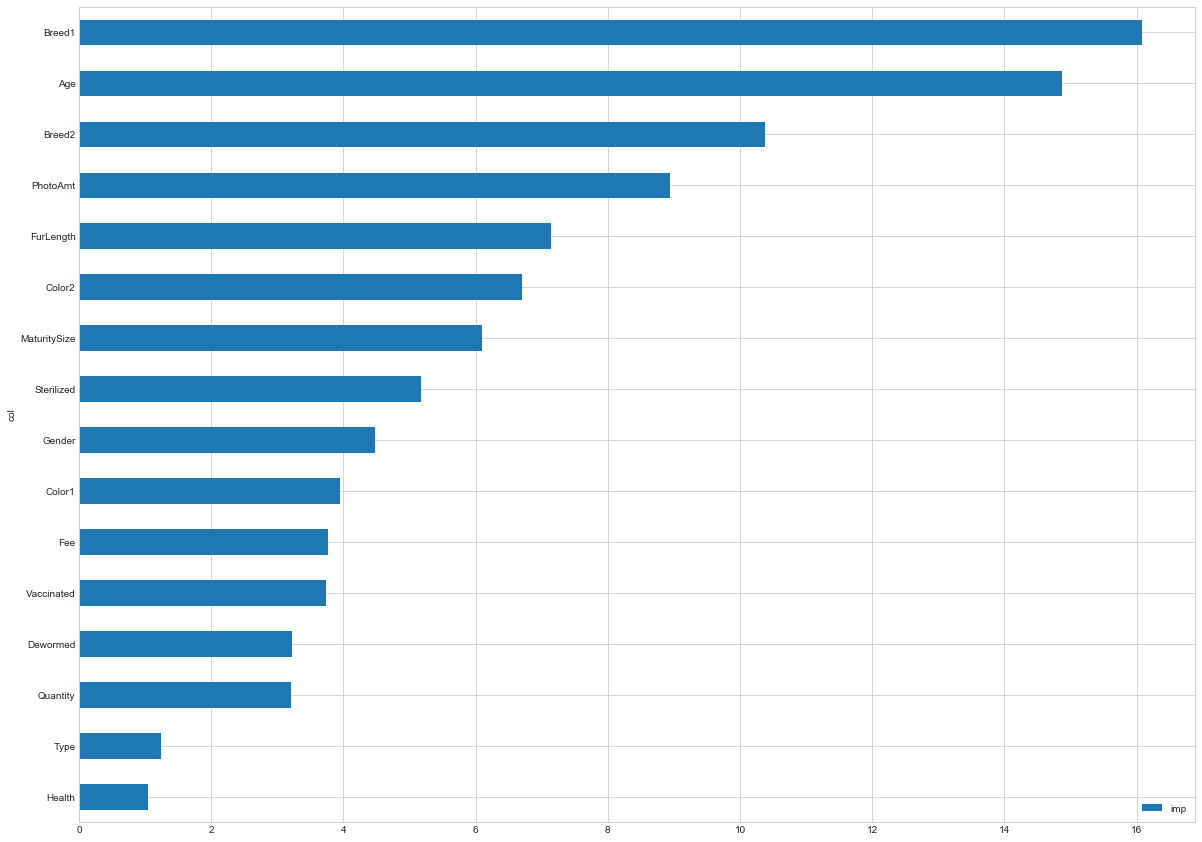

In [190]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)